In [137]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Perceptual decision-making
We will start by modeling a perceptual decision-making task, akin to the random dot kinematogram
discussed in the lecture. See Figure 2 of Dubreuil et al. [3].
1. Create a function for generating the data. Both the input u (noisy stimulus) and the
target output y (identity of the stimulus) are one-dimensional. The input is de ned by:
u(t) =
(
u +  (t); if 5   t   45
 (t) otherwise:
Here u is the stimulus strength, drawn uniformly from +- 3.2/100{1, 2, 4, 8, 16}, and \Epsilon is background
noise, drawn from a normal distribution with mean 0 and standard-deviation 0.03. The stimulus strength is re-sampled for each trial, the noise is re-sampled for each
time-step. The target y is defined as the sign of u. Write your function such that it can
generate multiple trials at the same time, this will be useful for training our network
using stochastic gradient descent. Plot the data for several trials to make sure the labels
match the inputs, and the noise levels are reasonable.

In [138]:
def generate_random_stimuli(n_stimuli: int, t_max: int = 75, t_start = 0, t_stim_start: int = 5, t_stim_end: int = 45, noise_mean: float = 0, noise_std: float = 0.03) -> np.ndarray:
    stimulus_strengths = np.random.choice([-16, -8, -4, -2, -1, 1, 2, 4, 8, 16], n_stimuli)*3.2/100
    stimuli = np.pad((stimulus_strengths * np.ones((t_stim_end - t_stim_start, n_stimuli))).T, ((0,0),(t_stim_start-t_start,t_max-t_stim_end)))
    noise = np.random.normal(noise_mean, noise_std, (n_stimuli, t_max - t_start))
    noisy_stimuli = stimuli + noise
    
    targets =  np.sign(stimulus_strengths)
    return torch.tensor(noisy_stimuli, dtype=torch.float32), torch.tensor(targets, dtype=torch.float64), stimulus_strengths

KeyError: tensor(1., dtype=torch.float64)

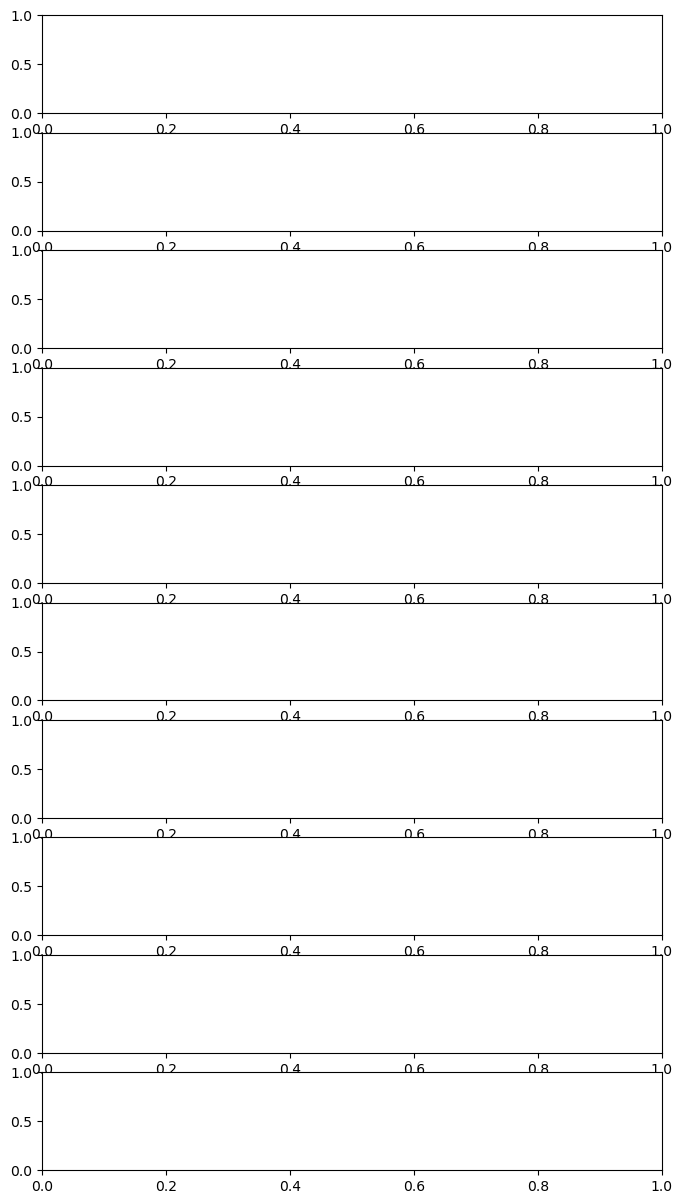

In [139]:
n_stimuli = 10
fig, ax = plt.subplots(n_stimuli, 1, figsize=(8,15))
colors = {-1: 'red', 1: 'blue'}
stimuli, targets, stimulus_strengths = generate_random_stimuli(n_stimuli)
for i in range(n_stimuli):
    ax[i].plot(stimuli[i], color = colors[targets[i]])
    ax[i].set_title("stimulus_strengths {}".format(stimulus_strengths[i]))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15,2))
plt.imshow(stimuli)

2. Implement the recurrent neural network in your favorite deep learning library. The
network has one-dimensional inputs and outputs, and an arbitrary number N of recurrent
units. Its trainable parameters are the left and right connectivity vectors m, n. It also
has  xed input and output weights I and w, respectively. All (trainable and  xed)
parameters are sampled from a standard normal distribution, with the exception of the
output weights, which are drawn with standard deviation of 4 (why?). The dynamics of
the ith unit are given by
 
dxi
dt
= 􀀀xi +
XN
j=1
Jij (xj) + Iiu(t); i = 1; : : : ;N :
Here   = tanh is the neuron's transfer function, and   = 100ms the neuronal time
constant. Simulate the network using forward Euler with a time step of  t = 20ms
(the stimulus duration of 75 time steps corresponds to 1500ms real time). The rank one
matrix J is de ned as
J=1
N
mnT :
The network's output is a linear readout of the rates:
z(t) =
1
N
XN
i=1
wi (xi):

In [141]:
class LowRankRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dt, tau):
        super(LowRankRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.dt = dt
        self.tau = tau
        
        # Initialize trainable parameters
        self.W_in = torch.normal(0, 1, size=(input_dim, hidden_dim), dtype=torch.float32)
        self.W_out = torch.normal(0, 4, size=(input_dim, hidden_dim), dtype=torch.float32)
        
        # Left and right connectivity vectors
        self.m = nn.Parameter(torch.normal(0, 1, size=(hidden_dim, )))
        self.n = nn.Parameter(torch.normal(0, 1, size=(hidden_dim, )))
        
    def forward(self, x, hidden):
        # Recurrent connectivity matrix
        J = torch.outer(self.m, self.n)  # Construct low-rank J
        
        # Compute hidden stat
        hidden_2 = hidden + self.dt*(x @ self.W_in + torch.tanh(hidden) @ J)/self.tau
        
        # Compute output
        output = (torch.tanh(hidden_2) @ self.W_out.T)/self.hidden_dim
        
        return output
            
def train(rnn, optimizer, loss_fn, hidden_0, mini_batch_size = 32, n_iter = 1000):
        
    for iter in range(n_iter):
        #generate input
        x, y, _ = generate_random_stimuli(mini_batch_size)
            
        #generate output, and hidden states
        output = rnn(x, hidden_0)
            
        #compute loss on output
        loss = loss_fn(output, y)
        print(loss)
        #propagate it back
        loss.backward()
            
        #update m and n
        optimizer.step()
        
        #reset gradient
        optimizer.zero_grad()
    
def MSE(outputs, targets, consider_last = 15):
    return torch.sum((outputs[:,consider_last:] - torch.reshape(targets,(-1, 1))) ** 2)/(len(targets)*consider_last)

torch.autograd.set_detect_anomaly(True)
# Example usage
input_dim = 75
hidden_dim = 128
output_dim = 1
mini_batch_size = 32
hidden_0 = torch.zeros((mini_batch_size, hidden_dim))
rnn = LowRankRNN(input_dim, hidden_dim, output_dim, 20, 100)
optimizer = torch.optim.Adam(rnn.parameters(), lr = 5e-03)

train(rnn, optimizer, MSE, hidden_0, mini_batch_size)

tensor(4.0407, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(4.1878, dtype=torch.float64, grad_fn=<DivBackward0>)


/usr/local/Caskroom/miniconda/base/envs/neurokin/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: Error detected in DivBackward0. Traceback of forward call that caused the error:
  File "/usr/local/Caskroom/miniconda/base/envs/neurokin/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Caskroom/miniconda/base/envs/neurokin/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/Caskroom/miniconda/base/envs/neurokin/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/Caskroom/miniconda/base/envs/neurokin/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/Caskroom/miniconda/base/envs/neurokin/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.start()
  File "/usr/local/Caskro

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.